# Exercise Sheet No. 8/9

> Machine learning for Natural Sciences, Summer 2025, T.T.-Prof.Pascal Friederich, pascal.friederich@kit.edu
>
> Deadline: **30.06.2025**
>
> Tutor: jonas.teufel@kit.edu
>
> **Please ask question in the forum/discussion board and only contact the Tutor directly when there are issues with the grading**

**Topic:** This assignment will focus on convolutional neural networks (CNNs) and recurrent neural networks (RNNs)

Please add here your group members' names and student IDs. 

You are encouraged to work in groups of a maximum of 3 people, however **each of you** has to submit a solution.

Names: Christopher Roth, Isabella Mebus Kishi de Oliveira

IDs: utxus, utmce

## ⚠️ Important Information

This is a special exercise. The first part of the notebook consists of a *regular* exercise aimed to introduce you to convolutional neural networks using the ``pytorch_lightning`` library. The second part of the notebook introduces the **🏆 Competition**. By entering the competition, you'll have the chance to win prizes according to your ranking or earn bonus points for the exercise based on your absolute performance.

While the first part of the exercise will be graded as usual, the competition is entirely *optional*!

You'll hopefully notice that the volume of the first part&mdash;the regular exercise&mdash;will be slightly reduced compared to the previous exercises to leave enough room to work on the competition. Additionally, there will be a total of *3 weeks* allocated for this exercise sheet, giving you the option to invest more time into the competition task.

---

**Installing dependencies.** For this exercise, the cell below will install additional dependencies which are not installed to the default Colab environment. We'll define the neural networks using the ``pytorch_lightning`` library and work with the ``breizhcrops`` dataset.

In [1]:
##### DO NOT CHANGE #####
%pip install lightning breizhcrops

##### DO NOT CHANGE #####

/Users/christopherroth/code/ml/ml_natural_sciences/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
##### DO NOT CHANGE #####
import os
import json
import zipfile
import random
import requests
import tempfile
import importlib.util
from rich.pretty import pprint
from itertools import islice
from typing import Any, Dict, List, Set, Optional, Tuple, Literal

import PIL
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
import lightning.pytorch as pl
from PIL.Image import Image as Image_
from PIL import Image
import breizhcrops as bzh

PATH: str = os.getcwd()
plt.style.use('default')

##### DO NOT CHANGE #####

In [3]:
##### DO NOT CHANGE #####
# Will be used to download assets from the BwSync&Share Nextcloud.
def nextcloud_download(url: str, raw: bool = False) -> str:
    """
    Downloads the content of a file from a nextcloud server and returns 
    it eithers as a string or a bytes object if the ``raw`` flag is set.
    """
    
    content = b''
    with requests.get(
        url,
        allow_redirects=True,
        headers={
            'User-Agent': 'Mozilla/5.0',
        },
        stream=True,
        timeout=60,
    ) as response:
        for index, chunk in enumerate(response.iter_content(chunk_size=8192 * 1000)):
            if chunk:
                content += chunk
        
    print(f"> Downloaded {len(content)} bytes from {url}")
    if not raw:
        content = content.decode('utf-8')
    
    return content

# Can be used to import python modules dynamically from nextcloud.
def nextcloud_import(module_name: str, url: str) -> Any:
    """
    Downloads a python module from a nextcloud server and imports it.
    """
    
    content: str = nextcloud_download(url, raw=True)
    module_path: str = os.path.join(tempfile.gettempdir(), f'{module_name}.py')
    with open(module_path, 'wb') as file:
        file.write(content)
    
    spec = importlib.util.spec_from_file_location(module_name, module_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    print('> Imported module:', module_name)
    
    return module

##### DO NOT CHANGE #####

In [4]:
##### DO NOT CHANGE #####
utils = nextcloud_import(
    module_name='utils',
    url='https://bwsyncandshare.kit.edu/s/x22fQopd9YCj5t3/download'
)

##### DO NOT CHANGE #####

> Downloaded 2497 bytes from https://bwsyncandshare.kit.edu/s/x22fQopd9YCj5t3/download
> Imported module: utils


## 8.1 CNNs and Pytorch Lightning

### 🧑‍🌾 The BreizhCrops Dataset

For the regular exercise on convolutional and recurrent neural networks we'll be working with the [BreizhCrops](https://github.com/dl4sits/BreizhCrops) dataset. BreizhCrops is a large-scale benchmark dataset designed for the supervised classification of field crops using satellite time series data. It comprises over 600,000 multivariate time series samples, each representing a crop field in the Brittany region of France. These samples are derived from Sentinel-2 satellite imagery, encompassing both top-of-atmosphere (L1C) and bottom-of-atmosphere (L2A) reflectance data across multiple spectral bands throughout the year 2017. Each time series is labeled with one of nine crop types.

In [5]:
##### DO NOT CHANGE #####
import breizhcrops as bzh
from rich.pretty import pprint

dataset = bzh.BreizhCrops(
    region="frh04",
    root='/tmp/bzh',
    preload_ram=True,
)

print(f'downloaded dataset with {len(dataset)} elements...')
print(f'type of dataset: {type(dataset)} - inheriting from: {dataset.__class__.__bases__}')

##### DO NOT CHANGE #####

loading data into RAM: 100%|██████████| 122614/122614 [00:12<00:00, 10031.06it/s]

downloaded dataset with 122614 elements...
type of dataset: <class 'breizhcrops.datasets.breizhcrops.BreizhCrops'> - inheriting from: (<class 'torch.utils.data.dataset.Dataset'>,)


### Data Exploration

In a first step we'll want to do some data exploration to better understand the dataset that we are working with. This will involve understanding the structure of the input data as well as a distribution of the target labels. We'll also want to visualize some of the data to get a more intuitive understanding.

**🛠️ Task 8.1 (1 point)** How many *features* does each time-series in the given dataset consist of? Assign your answer to the ``num_features`` variable below.

In [6]:
# TASK: Assign the number of *features* in the dataset to the variable below.

# YOUR CODE HERE
num_features: int = 17


In [7]:
##### DO NOT CHANGE #####
# ID: task-8-1-features - possible points: 1

assert isinstance(num_features, int), "num_features should be an integer"

# The hidden tests will check the correctness of your answer.

##### DO NOT CHANGE #####

**🛠️ Task 8.2 (1 point)** One important feature and a major challenge of time-series processing is that the different time-series elements in the dataset may have different lengths. Do the time series in this particular dataset have different lengths? Assign your yes/no answer to the ``time_series_answer`` variable below.

In [8]:
# TASK: Assign your yes/no answer to the variable below.

time_series_answer: Literal['yes', 'no'] = 'yes'

# YOUR CODE HERE
dataset.index


id CODE_CULTU                   path     meanCLD  sequencelength  \
idx                                                                             
0       6017564        PTR  csv/frh04/6017564.csv  780.075742             102   
6       6054675        PTR  csv/frh04/6054675.csv  731.428571              49   
7       6018665        PTR  csv/frh04/6018665.csv  710.530612              49   
8       6019318        PTR  csv/frh04/6019318.csv  770.534653             101   
9       6019435        RGA  csv/frh04/6019435.csv  600.625715              49   
...         ...        ...                    ...         ...             ...   
158327  5057907        PPH  csv/frh04/5057907.csv  633.608050              50   
158328  5057908        MIS  csv/frh04/5057908.csv  640.096150              50   
158330  5057910        MIS  csv/frh04/5057910.csv  662.517416              50   
158331  5057975        MIS  csv/frh04/5057975.csv  639.764726              50   
158332  5057976        MIS  csv/frh04/5057976.csv  648.850241              50   

        classid          classname region  
idx                                        
0             8  temporary meadows  frh04  
6             8  temporary meadows  frh04  
7             8  temporary meadows  frh04  
8             8  temporary meadows  frh04  
9             8  temporary meadows  frh04  
...         ...                ...    ...  
158327        7  permanent meadows  frh04  
158328        3               corn  frh04  
158330        3               corn  frh04  
158331        3               corn  frh04  
158332        3               corn  frh04  

[122614 rows x 8 columns]

In [9]:
##### DO NOT CHANGE #####
# ID: task-8-1-question - possible points: 1

assert isinstance(time_series_answer, str), "your answer should be a string"
assert time_series_answer.lower() in ['yes', 'y', 'no', 'n'], (
    "your answer should be either 'yes' or 'no'"
)

# The hidden tests will check the correctness of your answer.

##### DO NOT CHANGE #####

In the next step we want to get a visual impression of how time-series differ for the different classes in the dataset. For this purpose we are going to define a helper function ``extract_features_for_class`` which will extract only *a singe feature dimension* for the time series data and only for *a specific class*. As input the function receives two arrays: ``xs`` of multiple input time-series constructs and ``ys`` with the corresponding target labels. Additionally the function will recieve the information about which feature index and which class index to use.

**🛠️ Task 8.3 (2 points)** Implement the function ``extract_features_for_class`` according to the description given in the doc string.

In [10]:
def extract_features_for_class(xs: List[np.ndarray],
                               ys: List[np.ndarray],
                               class_index: int,
                               feature_index: int,
                               ) -> np.ndarray:
    """
    Given a list of multi-feature time-series input samples ``xs`` and a list of their corresponding labels ``ys`` 
    in the same order, this function extracts a single numpy array of the shape (num_elements, num_timesteps) 
    containing the values for the feature at index ``feature_index`` for all the *num_elements* samples of the class 
    with index ``class_index`` for all of the *num_timesteps* time-steps.
    
    :param xs: List of input samples, where each sample is a numpy array of shape (num_timesteps, num_features).
    :param ys: List of labels, where each label is a numpy array of shape (num_timesteps,).
    :param class_index: The index of the class to extract features for.
    :param feature_index: The index of the feature to extract.
    
    :return: A numpy array of shape (num_elements, num_timesteps) containing the values for the feature at index
        ``feature_index`` for all the samples of the class with index ``class_index``.
    """
    
    # YOUR CODE HERE
    features = []
    for x, y in zip(xs, ys):
        if y == class_index:
            features.append(x[:, feature_index])
    
    return np.array(features)


In [11]:
##### DO NOT CHANGE #####
# ID: task-8-3-extract - possible points: 2

xs_example = [np.random.rand(10, num_features) for _ in range(5)]
ys_example = [0, 1, 0, 1, 0]

result_example = extract_features_for_class(
    xs_example,
    ys_example,
    class_index=0,
    feature_index=1
)
assert isinstance(result_example, np.ndarray), "result_example should be a numpy array"
assert result_example.shape == (3, 10), "result_example should have shape (3, 10)"

# NOTE: The hidden tests will check more specific cases for the function.

##### DO NOT CHANGE #####

Using the previously extracted function, we can now visualize the average progression of various features over the given time frames for different classes and therefore get a visual clue about which kinds of characteristics might be indicative of different classes.

using random subset of the dataset with 10000 elements...
7 classes in the dataset: [0 1 2 3 5 7 8]
plotting the 7 feature for each class...


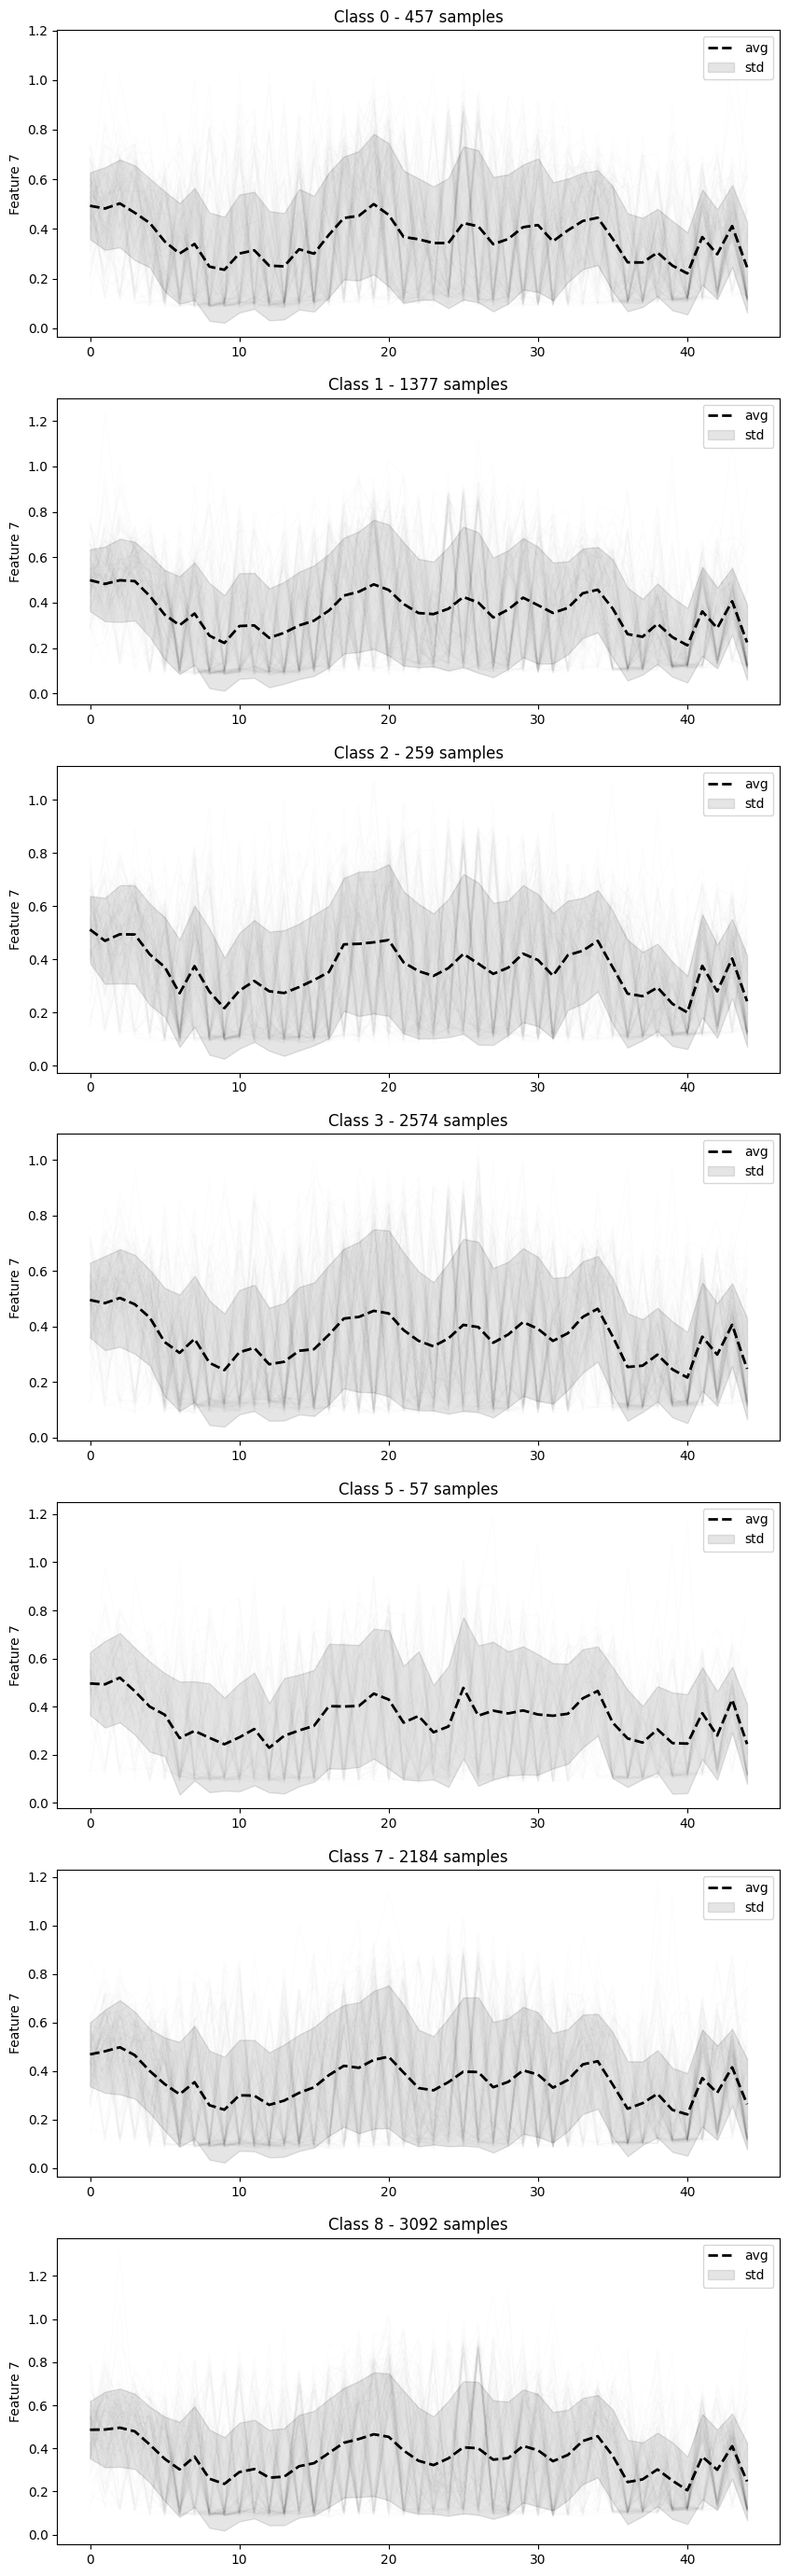

In [12]:
##### DO NOT CHANGE #####
random.seed(42)

# You may change this variable to plot different features. You may make modifications despite 
# this being a read-only cell. During the grading the modifcations will simply be reset!
FEATURE_INDEX: int = 7

NUM_ELEMENTS: int = 10_000
INDICES: List[int] = list(random.sample(range(len(dataset)), NUM_ELEMENTS))

dataset_subset = [dataset[i] for i in INDICES]
print(f'using random subset of the dataset with {len(dataset_subset)} elements...')

xs, ys = zip(*[(x.numpy(), y.numpy()) for x, y, _ in dataset_subset])

classes = np.unique(ys)
num_classes = len(classes)
print(f'{num_classes} classes in the dataset: {classes}')

fig, rows = plt.subplots(
    nrows=num_classes,
    ncols=1,
    figsize=(10, 5 * num_classes),
    squeeze=False,
)

print(f'plotting the {FEATURE_INDEX} feature for each class...')
for class_index, row in zip(classes, rows):
    
    result: np.ndarray = extract_features_for_class(
        xs,
        ys,
        class_index=class_index,
        feature_index=FEATURE_INDEX
    )
    
    ax = row[0]
    ax.set_title(f'Class {class_index} - {len(result)} samples')
    ax.set_ylabel(f'Feature {FEATURE_INDEX}')
    
    ts = np.arange(result.shape[1])
    ax.plot(
        ts, 
        np.mean(result, axis=0), 
        label='avg', 
        color='black', 
        linewidth=2,
        linestyle='--',
    )
    ax.fill_between(
        ts,
        np.mean(result, axis=0) - np.std(result, axis=0),
        np.mean(result, axis=0) + np.std(result, axis=0),
        alpha=0.1,
        color='black',
        label='std',
        zorder=-100,
    )
    
    for arr in islice(result, 100):
        ax.plot(ts, arr, alpha=0.002, color='black')
        ax.plot(ts, arr, alpha=0.002, color='black')    
        
    ax.legend(loc='upper right')

##### DO NOT CHANGE #####

And as we can see... we can't actually see much for the most part. Visually, the time series data is quite noisy and hard to interpret directly. There seem to be no clear indicators for one class over the another as the average progression of the features for the different classes is quite similar. However, this is exactly the case in which we'll need machine learning to make sense of complex data where we humans cannot!

One aspect we *should* notice, though, is the *label imbalance* in this dataset! There seem to be some classes for which significantly more samples are available than for others, which is something we need to keep in mind when training our models. This will present a significant challange for the model training and we'll have to keep this in mind.

In [13]:
##### DO NOT CHANGE #####
# Count the number of samples per class using numpy
ys_all = np.array([y.item() for _, y, _ in dataset])
classes_sorted, counts_sorted = np.unique(ys_all, return_counts=True)


##### DO NOT CHANGE #####

/var/folders/08/h7dqgln97rx04lcwp3lfcqb40000gn/T/ipykernel_16136/1160520114.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', num_classes)


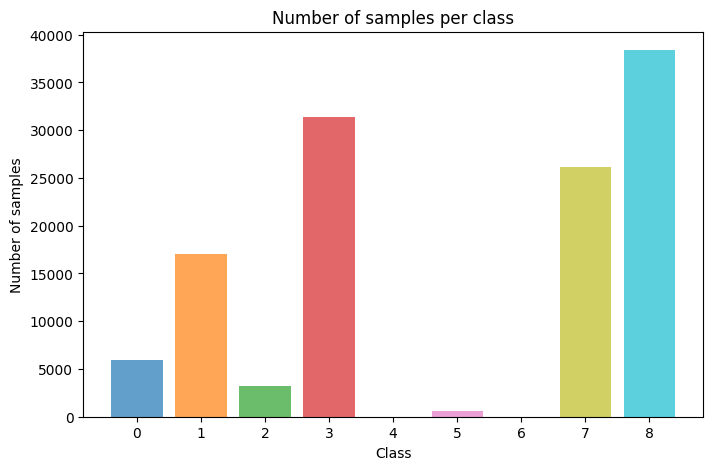

In [14]:
##### DO NOT CHANGE #####
import matplotlib.cm as cm

num_classes = len(classes_sorted)
class_counts = counts_sorted.tolist()
colors = cm.get_cmap('tab10', num_classes)

plt.figure(figsize=(8, 5))
for idx, (cls, count) in enumerate(zip(classes_sorted, counts_sorted)):
    plt.bar(cls, count, color=colors(idx), label=f'Class {cls}', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Number of samples per class')
plt.xticks(classes_sorted)
plt.show()


##### DO NOT CHANGE #####

### ⚡ Pytorch Lightning

After introducing the dataset, we'll subsequently try to develop neural networks to solve the task of classifying the different crops based on the satellity imagry data. Specifically, we'll develop the networks using the 🔥[Pytorch](https://docs.pytorch.org/tutorials/beginner/basics/intro) and ⚡[Pytorch Lightning](https://lightning.ai/docs/pytorch/stable/) libraries.

Alongside Google's *tensorflow* and *JAX*, Meta's *Pytorch* is one of the big modern machine learning frameworks widely adapted throughout industry and academia. The purpose of these large frameworks is to simplify the process of designing and developing neural network models by providing abstractions for a lot of common operations. Exercise 5 introduced the inner workings of neural networks on a foundational level, including training by backpropagation. Unlike the explicit implementation in the previous exercise, these large ML frameworks implement an *implicit* backward differentiation of complex neural network architectures such that the user/developer only has to explicitly implement the forward pass.

``pytorch_lightning`` is a library that is built on top of ``pytorch`` which streamlines the process of building, training, and validating deep learning models. It abstracts away much of the boilerplate code required for training loops, checkpointing, logging, and device management, allowing one to focus on the core logic of models and experiments. By enforcing a modular structure, Lightning encourages best practices and reproducibility, making it easier to scale experiments from a single laptop to distributed clusters with minimal code changes. In the following sections, we'll leverage these advantages to efficiently implement and train neural networks for crop classification.

**Online Tutorials.** The following exercises will guide you through the very fundamental basic of working with Pytorch+Lightning. If your are not familiar with these frameworks, it'd make sense to look into some brief tutorials to get a better understanding of the concepts and how to use them. The following resources may help you to get started:

In [15]:
##### DO NOT CHANGE #####
from IPython.display import YouTubeVideo

# Displaying YouTube videos directly in VSCode is not supported
video = None
if not 'VSCODE_PID' in os.environ: 
    
    # https://www.youtube.com/watch?v=ORMx45xqWkA
    # "PyTorch in 100 Seconds"
    video = YouTubeVideo('ORMx45xqWkA', width=800, height=450)
    
video

##### DO NOT CHANGE #####

In [16]:
##### DO NOT CHANGE #####
from IPython.display import YouTubeVideo

# Displaying YouTube videos directly in VSCode is not supported
video = None
if not 'VSCODE_PID' in os.environ: 
    
    # https://www.youtube.com/watch?v=khMzi6xPbuM
    # "Introduction to Coding Neural Networks with PyTorch and Lightning"
    video = YouTubeVideo('khMzi6xPbuM', width=800, height=450)
    
video

##### DO NOT CHANGE #####

### Pytorch Tensors

All data handling in pytorch is based on the ``torch.Tensor`` class. Functionally, these tensor objects are similar to ``numpy.ndarray``s. Pytorch tensors can also be easily converted to and from numpy arrays. One special feature of these tensor objects is that they save the gradient information that is required for automatic differentiation and optimization. This means that when operations are performed on tensors, PyTorch can keep track of these operations and automatically compute gradients for you during backpropagation. This feature is essential for training neural networks, as it allows for efficient and flexible computation of derivatives that are then needed to update the model weights.

You can make use of the automatic differentiation by setting the ``requires_grad`` flag to ``True`` when creating a tensor. This will enable PyTorch to track all operations on that tensor and compute gradients during the backward pass. You may then perform any differentiable operations on the tensor and call the ``backward()`` method to compute the gradients. The gradients will be stored in the ``grad`` attribute of the tensor. Note, however, that the backward pass will only work for scalar tensors, i.e., tensors with a single value!

In [17]:
##### DO NOT CHANGE #####
arr = np.random.rand(10, 12)

tens = torch.tensor(arr, requires_grad=True)
print(f'tensor of shape {tens.shape}')

# ~ tensor transformations

# The following code defines a non-linear transformation on the given tensor data structure
# (log, square) and then aggregates the result into a single value using a mean/average operation.
result = torch.log(tens ** 2)
result = torch.mean(result)
print(f'result of the transformation: {result:.3f} (type: {type(result)})')

# By simply calling the "backward" operation on the result, we can compute the gradient of the 
# transformation with respect to the input tensor.
result.backward()

# The contents of the "tens.grad" tensor will be the derivatives of the function with respect to 
# each individual input component.
# On a larger scale, this functionality is used by pytorch to optimize the parameters of a neural 
# network model with respect to the loss function using the backpropagation and gradient descent 
# algorithms.
print(f'gradient shape: {tens.grad.shape}, gradient values:')
pprint(tens.grad)

# Converting gradient values to numpy array
print('gradients as a numpy array:')
pprint(tens.grad.numpy())

##### DO NOT CHANGE #####

tensor of shape torch.Size([10, 12])
result of the transformation: -1.721 (type: <class 'torch.Tensor'>)
gradient shape: torch.Size([10, 12]), gradient values:


tensor([[0.0174, 0.1043, 0.0191, 0.0235, 0.0297, 0.0224, 0.0219, 0.0228, 0.0175,
│   │    0.0532, 0.0865, 0.0479],
│   │   [0.0169, 0.0212, 0.0365, 0.0450, 0.0443, 0.0595, 0.0203, 0.0219, 0.0685,
│   │    0.0463, 0.0263, 0.3531],
│   │   [0.0172, 0.0616, 0.0257, 0.0294, 0.0806, 0.0942, 7.2422, 0.0209, 0.0798,
│   │    0.0357, 0.0590, 0.0170],
│   │   [0.0602, 0.0314, 0.0318, 0.0169, 0.0271, 0.0174, 0.0226, 0.0350, 0.1045,
│   │    0.0403, 0.0658, 0.0251],
│   │   [0.0219, 0.1001, 0.0341, 0.0284, 0.0321, 0.0347, 0.0407, 0.1119, 0.0226,
│   │    0.0403, 0.0196, 0.0537],
│   │   [0.0254, 0.0306, 0.0299, 0.0259, 0.0219, 0.0188, 0.1531, 0.0294, 0.1702,
│   │    0.0188, 0.0988, 0.0181],
│   │   [0.0980, 0.0396, 0.0330, 0.0220, 0.0169, 0.0321, 0.0683, 0.0197, 0.0227,
│   │    0.0388, 0.1040, 0.0204],
│   │   [0.0411, 0.0308, 0.0284, 0.0477, 0.0358, 0.1015, 0.0210, 0.0481, 0.0242,
│   │    0.1192, 0.1994, 0.0603],
│   │   [0.0213, 0.0184, 0.0305, 0.0349, 0.0252, 0.0342, 0.0169, 0.2160, 0.0443,
│   │    0.5547, 0.0197, 0.1212],
│   │   [0.0216, 0.0212, 0.0261, 0.0822, 0.0669, 0.0632, 0.0232, 0.0209, 0.0274,
│   │    0.0169, 0.0254, 0.0197]], dtype=torch.float64)

gradients as a numpy array:


array([[0.0173621 , 0.10431684, 0.01907196, 0.02348153, 0.02972986,
│   │   0.02236068, 0.02191577, 0.02280336, 0.01745636, 0.053228  ,
│   │   0.08652227, 0.04788305],
│      [0.01686057, 0.02116474, 0.03646545, 0.0449567 , 0.04430217,
│   │   0.05946194, 0.02029023, 0.02185896, 0.06847726, 0.04633183,
│   │   0.02633805, 0.35307069],
│      [0.01719553, 0.06157884, 0.02569705, 0.02941164, 0.08061097,
│   │   0.09423253, 7.24217573, 0.02091647, 0.07979773, 0.03566349,
│   │   0.05900466, 0.01702258],
│      [0.06016975, 0.03137352, 0.03175167, 0.01687492, 0.02712393,
│   │   0.01743674, 0.0226375 , 0.03497816, 0.10452674, 0.04027735,
│   │   0.06575824, 0.02514421],
│      [0.02190118, 0.10012836, 0.03410292, 0.02835237, 0.0320917 ,
│   │   0.03470485, 0.04067924, 0.11188834, 0.02259508, 0.04030068,
│   │   0.01956907, 0.05369216],
│      [0.02538336, 0.03064693, 0.02994452, 0.02594356, 0.02185044,
│   │   0.01877663, 0.15307372, 0.0293852 , 0.17019238, 0.0187628 ,
│   │   0.0987531 , 0.0181122 ],
│      [0.0980366 , 0.03960823, 0.03295098, 0.02198858, 0.01692482,
│   │   0.032118  , 0.06832858, 0.01967135, 0.02274319, 0.03877968,
│   │   0.10402199, 0.02043172],
│      [0.04112444, 0.03076428, 0.02842214, 0.04773113, 0.03577185,
│   │   0.10147375, 0.02097291, 0.04806412, 0.02423506, 0.119178  ,
│   │   0.19939725, 0.06025165],
│      [0.02130012, 0.01843262, 0.03046794, 0.03488373, 0.02517165,
│   │   0.03420873, 0.0169003 , 0.21601269, 0.04425103, 0.55467245,
│   │   0.01973514, 0.12119394],
│      [0.02156472, 0.02118662, 0.02606095, 0.08224202, 0.06691129,
│   │   0.06315066, 0.02321006, 0.02094907, 0.02742097, 0.01690628,
│   │   0.02542927, 0.01971318]])

### Lightning Modules

To create a new neural network architecture based on the Pytorch Lightning library, you'll have to create a new model class inheriting from the ``LightningModule`` base class. This base class already pre-implements a lot of complexity in the background but also defines an interface that will have to be implemented to create a functional neural network model class. Specifically, the following methods will have to be implemented by us.

- The ``__init__`` constructor will have to define all of the different layers that will be used in the network.
- The ``forward`` method will receive a single input batch at a time and has to define how the input data is transformed by the various network layers to receive the final prediction result.
- The ``train_step`` method will also receive a single input batch at a time, as well as the corresponding ground truth target values. The method will have to implement how the training *loss value* is calculated based on the input, the network structure and the ground truth target values. This function should therefore make use of the ``forward`` implementation.
- The ``configure_optimizers`` method should define which optimizer to use for the training.

To illustrate a basic example, the following section will show how to define and train a very simple fully-connected network using Pytorch Lightning:

In [18]:
##### DO NOT CHANGE #####
class SimpleModel(pl.LightningModule):
    """
    Simple fully connected neural network to regress a 1D function.
    """

    def __init__(self,
                 num_inputs: int,
                 num_outputs: int,
                 num_units: int,
                 learning_rate: float = 1e-3,
                 **kwargs
                 ):
        # This calls the constructor of the pl.LightningModule class, which does a lot 
        # of magic to make the subsequent model definition work seemlessly.
        super(SimpleModel, self).__init__(**kwargs)
        
        # Define a very simple 3 layer fully connected neural network which 
        # transforms data structures with ``num_input`` features into ``num_outputs`` 
        # features.
        self.fc_1 = nn.Linear(num_inputs, num_units)
        self.fc_2 = nn.Linear(num_units, num_units)
        self.fc_3 = nn.Linear(num_units, num_outputs)
        
        # This will be required to configure the optimizer
        self.learning_rate = learning_rate

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Given the input tensor ``x`` of with the shape (batch_size, num_inputs), this 
        method will have to return a tensor of the shape (batch_size, num_outputs).
        """
        emb = x
        
        # We'll update the tensor by applying the previous defined series of linear 
        # (fully connected) layers to it (=matrix multiplication with the weights) and 
        # subsequently applying the ELU activation function to the result.
        emb = self.fc_1(emb)
        emb = F.elu(emb) # ELU activation will lead to a "smoother" output function
        
        emb = self.fc_2(emb)
        emb = F.elu(emb)
        
        emb = self.fc_3(emb)
        
        # Return the final result, which should - according to the layer definition - 
        # have the shape (batch_size, num_outputs).
        return emb
    
    def training_step(self, 
                   batch: Tuple[torch.Tensor, torch.Tensor], 
                   batch_idx: int,
                   **kwargs
                   ) -> torch.Tensor:
        """
        Given a ``batch`` of data - consisting of the input tensor x and the target values y, 
        this method computes the mean squared error (MSE) loss between the predicted values 
        according to the current network weights and the target values.
        """
        x, y = batch
        y_hat = self(x)
        
        # NOTE: It is *very* important that y and y_hat have the exact same shape! This is a 
        # common source of error. If y has shape (B, ) and y_hat has shape (B, 1), there will 
        # be no error but the training won't work as expected since the shapes will be 
        # broadcasted incorrectly!
        if y_hat.shape != y.shape:
            y_hat = y_hat.view_as(y)
                
        # Compute the loss
        loss = F.mse_loss(y_hat, y)
        
        # This function will log the loss such that it is later displayed in the progress 
        # bar for example.
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self) -> torch.optim.Optimizer:
        """
        This method is used to configure the optimizer for the training process.
        """
        optimizer = torch.optim.Adam(
            # This method will return the tensor of all the model weights which we'll 
            # have to pass to the optimizer so that it knows which weights to optimize.
            self.parameters(), 
            lr=self.learning_rate
        )
        return optimizer

##### DO NOT CHANGE #####

In [19]:
##### DO NOT CHANGE #####
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Create a dataset for the cosine function from -5 to 5
x_data = np.linspace(-5, 5, 200).reshape(-1, 1).astype(np.float32)
y_data = np.cos(x_data)

# Convert to torch tensors
x_tensor = torch.from_numpy(x_data)
y_tensor = torch.from_numpy(y_data)

# Create a torch dataset and dataloader
cosine_dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)
cosine_loader = torch.utils.data.DataLoader(cosine_dataset, batch_size=32, shuffle=True)

# Define and train the SimpleModel
model = SimpleModel(num_inputs=1, num_outputs=1, num_units=32, learning_rate=2e-3)

store_models_callback = utils.StoreModelsCallback(
    pl_module_class=lambda: SimpleModel(num_inputs=1, num_outputs=1, num_units=32),
    k=5,
)

# To train the model now, there is no need to manually define a training loop
# or perform the backward pass. All this functionality is pre-implemented 
# by the Trainer class provided by pytorch lightning.
trainer = pl.Trainer(
    max_epochs=300,
    callbacks=[
        store_models_callback,    
    ]
)
trainer.fit(model, cosine_loader)

# Plot the results
with torch.no_grad():
    
    y_pred = model(x_tensor).numpy()
    
    epoch_y_pred_map = store_models_callback.forward_all(x_tensor)
    epoch_y_pred_map = {epoch: preds.numpy() for epoch, preds in epoch_y_pred_map.items()}

epochs = sorted(epoch_y_pred_map.keys())

# Prepare the figure for animation
fig_anim, ax_anim = plt.subplots(figsize=(8, 4))
ax_anim.plot(x_data, y_data, label='True cos(x)', linewidth=2, color='black', zorder=100)
line, = ax_anim.plot([], [], label='Model prediction', color='red')
ax_anim.set_title('Model prediction vs True function (Animation)')
ax_anim.set_xlabel('x')
ax_anim.set_ylabel('y')
ax_anim.legend()

# Animation update function
def update(frame):
    epoch = epochs[frame]
    y_pred_epoch = epoch_y_pred_map[epoch]
    line.set_data(x_data.flatten(), y_pred_epoch.flatten())
    ax_anim.set_title(f'Model prediction vs True function (Epoch {epoch})')
    return line,

# Create the animation
anim = FuncAnimation(
    fig_anim, update, frames=len(epochs), interval=500, blit=True
)

plt.close(fig_anim)  # Prevent duplicate static plot in notebook

# Display the animation in the notebook
HTML(anim.to_jshtml())

##### DO NOT CHANGE #####

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc_1 | Linear | 64     | train
1 | fc_2 | Linear | 1.1 K  | train
2 | fc_3 | Linear | 33     | train
----------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/christopherroth/code/ml/ml_natural_sciences/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


### Convolutional Neural Networks

After a brief introduction to Pytorch Lightning we'll now try to define a ``LightningModule`` model for the BreizhCrops dataset. Specifically we are going to use a *Convolutional Neural Network (CNN)* here. We are able to do so since the time-series data contained in the dataset have the same number of time-steps. Without further modifications, CNNs can only be applied to tasks with consistent input shapes. If the time-series we are dealing with had different sizes we'd be forced to use more flexible network archicture such as a Recurrent Neural Network (RNN).

Traditionally, the use of CNNs may be known from the image processing domain. In image processing a convolutional layer defines a set of *learnable* filter kernels which are applied to the given input image by using a 2D *convolution* operation. Intuitively speaking, after training, these convolutional layers become task-specific feature extractors for different semantically relevant patterns. In the classic example of cat/dog classification, one may find that certain filters become highly activated to the pattern of ears, snouts, eyes etc. of the different animals.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*XbuW8WuRrAY5pC4t-9DZAQ.jpeg">

However, in this case we are not dealing with 2D image data but with 1D time-series data. Convolutional layers can be applied in much the same way here&mdash;the only difference being that they are based on the 1-dimensional convolution operation.

The following section will give a brief introduction to the relevant pytorch implementations of these kinds of layers and their important characteristics.

In [20]:
##### DO NOT CHANGE #####

# Input tensors have the shape (batch_size, num_features, num_time_steps)
tens: torch.Tensor = torch.rand(1, 3, 10)
print(f'random tensor with shape: {tens.shape}')

# 1D convolutional layer
lay_conv = nn.Conv1d(
    in_channels=3, 
    out_channels=5, 
    kernel_size=3,
)

result = lay_conv(tens)
print(f'convolution result: {result.shape}')

##### DO NOT CHANGE #####

random tensor with shape: torch.Size([1, 3, 10])
convolution result: torch.Size([1, 5, 8])


In the previous example, the input data is a 1D tensor of the shape ``(batch_size, num_features, num_timesteps)``. The ``Conv1d`` layer has to be constructed with the information of how many features the input data has (in this case 3) but does not require the information about the number of time-steps! The ``out_channels`` parameter determines how many features the output data structure will have. The ``kernel_size`` parameter defines the size of the filter kernel that will be applied to the input data.

As you can see in the example, the layer transforms a time-series tensor with 3 features into one with 5 features using a convolutional kernel of size 3. However, the output tensor has a smaller number of time-steps than the input tensor due to the handling of the edges! In practice, this is often not desired.

**🛠️ Task 8.4 (1 point)** Consult the pytorch documentation for the ``Conv1d`` layer to find out how to achieve an output data structure with the same number of time-steps as the input data and assign ``lay_conv_same`` 

In [21]:
# Create a new layer object and assign it to the variable
lay_conv_same: nn.Conv1d = nn.Conv1d(
    in_channels=3, 
    out_channels=5, 
    kernel_size=3,
    padding='same',  # This will ensure that the output shape is the same as the input shape
)

# YOUR CODE HERE


In [22]:
##### DO NOT CHANGE #####
# ID: task-8-4-conv - possible points: 1

assert isinstance(lay_conv_same, nn.Conv1d), "lay_conv_same should be a Conv1d layer"
assert lay_conv_same.in_channels == 3, "lay_conv_same should have 3 input channels"
assert lay_conv_same.out_channels == 5, "lay_conv_same should have 5 output channels"
assert lay_conv_same.kernel_size == (3,), "lay_conv_same should have a kernel size of 3"

x_test = torch.rand(1, 3, 10)
result_test = lay_conv_same(x_test)
assert result_test.shape == (1, 5, 10)

# Hidden tests will check for other shapes

##### DO NOT CHANGE #####

Now we finally want to implement our crop classification model!

**🛠️ Task 8.5 (2 points)** Implement the constructor of the ``CropClassificationModel`` class. The model should consist of the following layers:
- $5 \times$ ``Conv1d`` layers with the ``num_features`` and the ``kernel_size`` parameters defined by the constructor arguments. After each convolutional layer, a ``ReLU`` activation function should be applied.
- Flattening of the output of the last convolutional layer.
- $3 \times$ ``Linear`` relu-activated, fully-connected layers with the ``num_features`` taking the flattened convolutional features as input and producing an output with the number of classes in the given dataset.

**🛠️ Task 8.6 (2 points)** Implement the ``forward`` method of the ``CropClassificationModel`` which first applies the convolutional layers to the input time-series, flattens the result and applies the fully-connected layers for the final multi-classification output.

**🛠️ Task 8.7 (1 point)** Implement the ``training_step`` method of the ``CropClassificationModel`` class. The training should use a CrossEntropy loss function for the multi-classification training. You'll find how to apply this loss in the Pytorch Documentation. Specifically make sure that your loss function uses the ``class_weights`` argument to account for the class imbalance in the dataset!


*Hint:* Consult the pytorch documentation for the ``Conv1d`` layer and compare this with the shape of the input tensors supplied by the given dataset. It might be that you'll have to do some reshaping in the implementation of your forward method!

In [23]:
class CropClassificationModel(pl.LightningModule):
    """
    A simple model for classifying the crops in the BreizhCrops dataset.
    """
    
    def __init__(self,
                 num_features: int,
                 kernel_size: int = 3,
                 learning_rate: float = 1e-4,
                 class_weights: Optional[torch.Tensor] = None,
                 **kwargs
                 ):
        """
        :param num_features: The number of features in the input data.
        :param num_classes: The number of output classes.
        :param kernel_size: The size of the convolutional kernel to be used.
        :param learning_rate: The learning rate for the optimizer.
        :param class_weights: A tensor with shape (num_classes, ) for weighted loss.
        """
        super().__init__()
        self.save_hyperparameters()

        self.learning_rate = learning_rate
        self.class_weights = class_weights

        # Conv1D expects (batch_size, in_channels, sequence_length)
        # So we need to treat features as in_channels

        conv_layers = []
        in_channels = num_features
        out_channels = num_features  # keeping same number of features

        for _ in range(5):
            conv_layers.append(nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2))
            conv_layers.append(nn.ReLU())

        self.conv = nn.Sequential(*conv_layers)

        # We'll infer the flattened size dynamically in forward using an adaptive layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(num_features * 100, num_features)  # placeholder for input size
        self.fc2 = nn.Linear(num_features, num_features)
        self.fc3 = nn.Linear(num_features, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        :param x: Input tensor of shape (batch_size, num_time_steps, num_features)
        :returns: Output tensor of shape (batch_size, num_classes)
        """
        # Transpose to (batch_size, num_features, num_time_steps) for Conv1D
        x = x.transpose(1, 2)
        x = self.conv(x)

        # Flatten (batch_size, num_features, time_steps)
        x = self.flatten(x)

        # Adjust fully connected input size dynamically on first use
        if not hasattr(self, "fc1_initialized"):
            self.fc1 = nn.Linear(x.shape[1], self.hparams.num_features)
            self.fc1_initialized = True

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def training_step(self, 
                      batch: Tuple[torch.Tensor, torch.Tensor, int], 
                      **kwargs
                      ) -> torch.Tensor:
        """
        Computes and returns the loss for a training batch.
        """
        x, y, _ = batch
        logits = self.forward(x)

        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, y)

        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


In [24]:
##### DO NOT CHANGE #####
# ID: task-8-5-constructor - possible points: 2

model = CropClassificationModel(
    num_features=32,
)
assert isinstance(model, CropClassificationModel), "model should be an instance of CropClassificationModel"

num_parameters = sum(p.numel() for p in model.parameters())
print(f'number of parameters: {num_parameters}')

assert num_parameters > 50_000, (
    "the model should have at least 50,000 parameters if implemented correctly"
)

# Count the number of Conv1d layers in the model (including nested modules)
conv1d_count = sum(1 for m in model.modules() if isinstance(m, nn.Conv1d))
print(f'Number of Conv1d layers: {conv1d_count}')
assert conv1d_count >= 5, "There should be at least 5 Conv1d layers in the model"

# Count the number of Linear layers in the model (including nested modules)
linear_count = sum(1 for m in model.modules() if isinstance(m, nn.Linear))
print(f'Number of Linear layers: {linear_count}')
assert linear_count >= 3, "There should be at least 3 Linear layers in the model"

# The hidden tests will check if the model can also be correctly instantiated with 
# different constructor parameters.

##### DO NOT CHANGE #####

number of parameters: 119305
Number of Conv1d layers: 5
Number of Linear layers: 3


In [25]:
##### DO NOT CHANGE #####
# ID: task-8-6-forward - possible points: 2

model = CropClassificationModel(
    num_features=32,
    kernel_size=3,
    learning_rate=1e-3,
)

# Performing a model forward pass
x_test = torch.rand(2, 45, 32, requires_grad=True)
out_test = model.forward(x_test)
print(f'output shape: {out_test.shape}')
pprint(out_test)

assert isinstance(out_test, torch.Tensor), "out_test should be a tensor"
assert out_test.shape == (2, 9), (
    "out_test should have shape (2, 9) for the 9 output classes"
)

# It should be possible to compute the derivatives through the forward pass of the model
mean_test = out_test.mean()
mean_test.backward()

assert isinstance(x_test.grad, torch.Tensor), (
    "x_test.grad should be a tensor with the same shape as x_test "
    "automatic differentiation through the forward pass should be possible"
)

# Hidden tests will check for other input batch shapes

##### DO NOT CHANGE #####

output shape: torch.Size([2, 9])


tensor([[-0.1517,  0.0533, -0.2265,  0.1360,  0.1831,  0.1858,  0.0441,  0.1395,
│   │     0.0650],
│   │   [-0.1518,  0.0530, -0.2268,  0.1362,  0.1829,  0.1859,  0.0435,  0.1403,
│   │     0.0649]], grad_fn=<AddmmBackward0>)

In [26]:
##### DO NOT CHANGE #####
# ID: task-8-7-training-step - possible points: 1

model = CropClassificationModel(
    num_features=32,
    kernel_size=3,
    learning_rate=1e-3,
)

# Performing a model forward pass with mock data
x_test = torch.rand(64, 45, 32, requires_grad=True)
y_test = torch.randint(0, 9, (64, ), dtype=torch.long) # class index
#y_test = F.one_hot(y_test, num_classes=7).to(torch.float32) # one-hot encoding

out_test = model.forward(x_test)

# The training_step method should return the loss value
loss_test = model.training_step((x_test, y_test, 0))
print(f'loss shape: {loss_test.shape}')
assert isinstance(loss_test, torch.Tensor), "loss_test should be a tensor"
assert loss_test.shape == torch.Size([]), (
    "loss_test should be a scalar tensor with a single value"
)

# Checking if the loss is correctly computed by comparing to the reference implementation

##### DO NOT CHANGE #####

loss shape: torch.Size([])


/Users/christopherroth/code/ml/ml_natural_sciences/.venv/lib/python3.11/site-packages/lightning/pytorch/core/module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Now that everything is implemented and working, we can start training the model. For this purpose, we will use the ``Trainer`` class from the ``pytorch_lightning`` library. This class takes care of all the training and validation loops, as well as logging and checkpointing.

In [27]:
##### DO NOT CHANGE #####
import random
from torch.utils.data import Subset

class_weights = np.array([1.0 / np.max([count, 2000]) for count in class_counts])
class_weights = torch.tensor(class_weights / np.max(class_weights))
pprint(class_weights)

# Create a new model
model = CropClassificationModel(
    num_features=64,
    kernel_size=3,
    learning_rate=1e-3,
    class_weights=class_weights,
)

# Load the dataset again
dataset = bzh.BreizhCrops(
    region="frh04",
    root='/tmp/bzh',
    preload_ram=True,
)
subset = Subset(dataset, random.sample(range(len(dataset)), 50_000))

# Create a DataLoader for the dataset
dataloader = torch.utils.data.DataLoader(
    subset,
    batch_size=128,
    # It's important to use "shuffle" for a train dataloader to ensure that each batch is actually 
    # a random sample of the dataset. Otherwise, the model can overfit to the order of the elements
    # in the dataset!
    shuffle=True,
    num_workers=8,
)

# Create a Trainer object
trainer = pl.Trainer(
    max_epochs=25,
    accelerator='auto',
)
trainer.fit(
    model,
    dataloader,
)

##### DO NOT CHANGE #####

tensor([0.3346, 0.1177, 0.6180, 0.0638, 1.0000, 1.0000, 1.0000, 0.0766, 0.0521],
│      dtype=torch.float64)

loading data into RAM: 100%|██████████| 122614/122614 [00:11<00:00, 10736.85it/s]
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | conv    | Sequential | 61.8 K | train
1 | flatten | Flatten    | 0      | train
2 | fc1     | Linear     | 409 K  | train
3 | fc2     | Linear     | 4.2 K  | train
4 | fc3     | Linear     | 585    | train
-----------------------------------------------
476 K     Trainable params
0         Non-trainable params
476 K     Total params
1.905     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode
/Users/christopherroth/code/ml/ml_natural_sciences/.venv/lib/python3.11/site-packages/lightning/pytorch

RuntimeError: Please call `iter(combined_loader)` first.

## Model Evaluation

**🛠️ Task 8.8 (1 point)** Now that we have trained your model, it's important to evaluate its performance in a more detailed way. For that, your final task is to implement the ``evaluate`` function below. The input of the model should be two arrays containing the ground truth target values and an array containing the model predictions. The output of the function should be a tuple of 3 values:
- A confusion matrix of the shape ``(num_classes, num_classes)`` 
- A float value for the top-1 accuracy of the model
- A float value for the macro [averaged F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

# Implement the function to compute the confusion matrix
def evaluate(y_true: np.ndarray,
             y_pred: np.ndarray,
             ) -> Tuple[np.ndarray, float, float]:
    """
    Computes the evaluation metrics from the true labels ``y_true`` and the predicted labels ``y_pred``.
    Returns a tuple of the three values:
    - confusion matrix of the shape (num_classes, num_classes)
    - accuracy score value
    - macro-averaged F1 score value
    
    :param y_true: true labels vector of shape (num_elements, num_classes)
    :param y_pred: predicted labels vector of shape (num_elements, num_classes)
    
    :return: tuple (confusion_matrix, accuracy, f1_score)
    """
    
    # YOUR CODE HERE
    raise NotImplementedError()


In [ ]:
##### DO NOT CHANGE #####
# ID: task-8-8-evaluation - possible points: 1


y_true = np.array([[0, 1, 0], [0, 1, 0], [1, 0, 0], [0, 0, 1]])
y_pred = np.array([[1, 0, 0], [0, 1, 0], [1, 0, 0], [0, 1, 0]])

cm, acc_value, f1_value = evaluate(y_true, y_pred)

print(f'Accuracy: {acc_value:.2f}')
print(f'F1 score: {f1_value:.2f}')
print('Confusion matrix:')
pprint(cm)

assert np.isclose(acc_value, 0.5, atol=0.01), "accuracy should be close to 0.5"
assert np.isclose(f1_value, 0.39, atol=0.01), "f1 score should be close to 0.39"
assert cm.shape == (3, 3), "confusion matrix should have shape (3, 3)"

# NOTE: The hidden tests will check for correcteness in more cases.

##### DO NOT CHANGE #####

Now we can apply the function to evaluate the performance of our model. In the end, we have a dataset of the shape that 

In [ ]:
##### DO NOT CHANGE #####
def evaluate_breizh_dataset(model: nn.Module,
                            region: str = 'belle-ile',
                            ) -> None:
    """
    Evaluates the model on the BreizhCrops dataset and prints the accuracy, F1 score, and confusion matrix.
    
    :param model: The trained model to evaluate.
    """
    
    # Set the model to evaluation mode
    model.eval()
    
    # Create a DataLoader for the dataset
    dataset = bzh.BreizhCrops(
        region=region,
        root='/tmp/bzh',
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=32,
        shuffle=False,
    )

    model.eval()

    y_true = []
    y_pred = []
    for batch in dataloader:
        x, y, *_ = batch
        
        with torch.no_grad():
            outputs = model(x)
            pred = outputs.argmax(dim=1)
        
            y_true.extend(F.one_hot(y, num_classes=9).cpu().numpy())
            y_pred.extend(F.one_hot(pred, num_classes=9).cpu().numpy())
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    cm, acc_value, f1_value = evaluate(y_true, y_pred)
    print(f'Accuracy: {acc_value:.2f}')
    print(f'F1 score: {f1_value:.2f}')
    print('Confusion matrix:')

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    

evaluate_breizh_dataset(model, region='belle-ile')

##### DO NOT CHANGE #####

---

## 🏆 8.2 Competition

This year, exercises 8 and 9 have been combined to provide enough time for an extended mid-term *AI competition* with the option to win prizes and to earn bonus points for the ML4NAT exercise.

Participation in the competition part of the exercise is completely **optional**. The points awarded through the competition are bonus points which may increase the final percentage of this exericise sheet beyond 100%&mdash;contributing to the final average accordingly. 

## How it Works

The competition takes place between *Monday, 09.06.2025* and *Monday, 30.06.2025*. This means, unlike previous exercises, there is a total of **3 weeks** available to work on this competition. Consequently the competition notebook woll have to be submitted **Monday, 30.06.2025** to ILIAS the *latest*!

In this competition you'll have to solve a regression task, possibly applying all of the machine learning knowledge you've acquired in the lecture until now, as well as your own creative problem solving skills. Further down, you'll receive the detailed instructions along with a training dataset. Your task is to develop a (machine learning) method to solve the given problem. After submitting the notebook, your model will be used to optain predictions for a *held-out* test set. By comparing the predictions of your model with the true target values, you'll receive a *performance score (PS)* which will be used to determine the winners of the competition and to distribute the bonus points.

### 🎁 Prizes

In total, there are **two prizes** available, which will be distributed to the **top 2** submissions according to the performance score on the held-out test set.

The prizes are as follows:
- **1st Place**: A Raspberry Pi 5
- **2nd Place**: A Raspberry Pi Zero Compute Module

*If* you win a prize, you'll be notified by an additional email&mdash;separate from the exercise's grading results! To receive your price you'll *have to* attend the in-person exercise on the *Friday, 04.06.2025*.

<div class="alert alert-block alert-warning">
<b>Note - Working Together.</b> For the competition, you are still welcome to collaborate with your fellow students to develop the general methodology of your solution. However, in the end, each of you will have to train and submit  their own independent model. If two solutions yield the <em>exact same</em> predictions they will be <em>disqualified</em> from the competition!
</div>

### 📝 Grading

Inpendently of the prizes, it's possible to receive *bonus points* for the ML4NAT Exercise. Through these bonus points it is possible to achieve a grade over 100% on this exercise sheet - which will be taken into account accordingly in the calculation of the final exercise grade at the end of the semester.

Rather than a relative ranking, the bonus points will be awarded according to absolute performance thresholds:

- **3 points** - performance score PS > 0.45
- **6 points** - performance score PS > 0.60
- **9 points** - performance score PS > 0.75

## 🎯 The Task

### Motivation

You decide to collaborate with a group of physicists to develop a machine learning model to decode the information contained in special *diffractogram patterns*.

The physicists use special equipment to determine a certain material property $y$ - which is a continuous value in the range $[-3, 3]$. However, the equipment cannot directly measure the desired property. Instead it creates visual artifacts called *diffractograms*. These visual artifacts manifrest as a series of concentric circular patterns of different thickness in front of a dark background, where the distribution and thickness of the individual rings contains information about the desired property $y$ implicitly.

The physicists provide you with a large dataset of annotated diffractograms for a number of materials with known property values $y$. Your task is to train a model to determine the value $y$ given the visual representation of the corresponding diffractogram!

After you've successfully implemented your model, your collaborators would like to apply your method on future diffractorgrams for whcih the property y isn't already known. In addition, the physicists also found a box of old diffractogram images in the basement of the institute, which were left behind by previous generations of researchers. They would be particularly interested to user your model on these older records as well - presenting a special challenge since previous generations of measurement equipment introduced significantly more irregularities in the output images!

Through a significant amount of manual work, the physicists were able to determine the true values $y$ for a small subset of 15 basement diffractograms which you'll be able to use to validate your model!

### Task Description

You receive a dataset consisting of 5000 annotated diffractograms where each element is a $256\times 256$ pixel RGB image saved in the PNG format associated with a true value $y \in [-3, 3]$. You may use this dataset as you wish to train your model / develop your method.

Your task is to develop a model which takes a diffractorgram image as an input and produces a prediction of the continuous property $y$ as an output.

Specifically, your model will have to implement the ``DiffractorgramInterface`` which is shown below.

Upon submission, your model will be evaluated on a set of 250 test set samples from the basement of the institute.

### Calculation of the Performance Score (PS)

The performance score will be calculated as follows:

In the basement test dataset, there are different categories of distortions present. During the evaluation, a separate $R^2$-Score will be calculated for each distinct type of distortion and the Performance Score (PS) will be calculated as the arithmetic mean over all individual scores.

$$
PS = \frac{1}{\text{number of distortion types}} \sum_{i} R^2_{\text{distortion},i}
$$

### 💡 Hints

✳️ **Distribution Shift.** Beware that it should be relatively easy to achieve very high accuracy on the training samples. The primary challenge of this competition lies in the handling of the distortions present throughout the basement samples. As you will see, the distortions will severly impact the prediction performance of most machine learning methods as they represent a drastic distribution shift compared to the (clean) training data.

✳️ **Possible Solutions.** You are strongly encouraged to solve the task using some kind of neural network model, as it will get you good results the quickest. However, you are not *obligated* to use deep learning methods. You may also try traditional machine learning approaches or computer vision techniques. Ultimately, the best solution will likely consist of a clever combination of traditional pre-processing and machine learning.

✳️ **Distortion Types.** The 15 basement samples you receive for the validation of your model represent *all* the different distortion types that will be present in the evaluation test set. All distortion types appear with the same frequency in the test set. Each image is afflicted with exactly one type of distortion.

✳️ **Available Libraries.** To implement your model and algorithms you may only use libraries which are available in the given environment by default and the additional ``pytorch_lightning`` package introduced at the beginning of this notebook. Most importantly, the available packages include the common machine learning frameworks ``torch``, ``tensorflow`` and ``jax`` along with basic libraries such as ``numpy``, ``pandas`` and ``scikit-learn``. In total, these available libraries will be more than sufficient to solve the given task.

✳️ **Remove Training Code.** During the grading of your notebook, each cell has a certain (relatively low) execution timeout. If the execution of the cell exceeds this timelimit it will be forcefully terminated. We need to enforce such a timeout to ensure that all student notebooks can be evaluated within a reasonable timeframe. In practice, this means that for your final submission you should *NOT* include the lengthy model training process. Instead, you'll have to find some way to train your model, save it into a persistent format and then load this trained model in your final submission *without* re-executing the training code. Every major machine learning library offers some pre-built functionality for this process and an explicit example implementation will be given further below.

✳️ **Limit Inference Times.** During the grading of your final submission, the predictions of your model will have to be evaluated on the full test set. Due to the aforementioned cell execution timeout (max. 5 minutes per cell), it is important that a single forward pass of your model doesn't take too long. Beware of this aspect when attempting to implement algorithmic solutions or extensive pre-processing steps.

✳️ **No Internet Access.** During the grading our your submission, there will only be restricted internet access. Specifically, the only reachable site will be the university's BwSync&Share Cloud. The cloud will be accessible to allow you to fetch trained versions of the model from your own file storage. More importantly, this means that you won't be able to use any external online services as part of your solution.  

In [28]:
##### DO NOT CHANGE #####
class DiffractogramInterface:
    """
    This class defines the Interface you'll need to implement / inherit from to 
    solve the diffractogram regression task. Each subclass needs to override 
    an implementation of the ``forward_image`` method, which takes an Image object 
    as input and should return as ingle float-valued prediction.
    """
    
    def forward_image(image: Image, **kwargs) -> float:
        """
        This function should be implemented in a subclass. The function 
        takes a ``PIL.Image`` object representing a diffractogram as an input 
        and returns a float value representing the model prediction.
        """
        
        # 1. e.g. Converting the Image object to a torch tensor
        # 2. Running the forward pass of your model
        # 3. Returning the model prediction as a python float value
        
        raise NotImplementedError(
            "This method should be implemented in a subclass!"
        )

##### DO NOT CHANGE #####

### Data Loading

The following section implements the data loading of the training dataset. The dataset is provided in the form of a ZIP file containing one PNG file and a JSON file for *each* sample. The PNG file contains the actual diffractogram image while the JSON file contains the additional metadata including the true value $y$ for the sample.

The functions defined in the following section will implement most of the data loading. Ultimately the dataset will be returned in a dictionary structure, where the keys are the sample IDs and the values are dictionaries containing the image information and the metadata information in the following structure:
```python
index_data_map = {
    # ...
    0: {
        "image": <PIL.Image.Image>,  # The diffractogram image
        "data": {
            "target": -2.553,        # The true value y for the sample
            "index": 0,              # The index of the sample
        }
    },
}
```

In [29]:
##### DO NOT CHANGE #####
def load_diffractogram_dataset(path: str) -> Dict[int, dict]:
    """
    Given the absolute string ``path`` to a folder containing the dataset, 
    this function will load the dataset and return a index data map dictionary 
    structure containing the images and the correspondign target value 
    annotations.
    
    The dataset folder is expected to contain a set of files where each element 
    of the dataset is represented by a pair of files: a PNG image and a JSON
    file. The PNG image contains the diffractogram, while the JSON file
    contains the target value for the corresponding image. The files are
    named using the same index, e.g.:
    - 0.png, 0.json
    
    :param path: The absolute path to the folder.
    
    :return: A dicionary mapping the index of the dataset element to a 
        dictionary containing the image and the target value.
    """
    
    # We'll use this data structure to store the dataset as we load 
    # it from the folder structure.
    index_data_map: Dict[int, dict] = {}
    
    # This set will contain all the string representations of the 
    # dataset indices.
    indices: Set[str] = set([
        name.split('.')[0]
        for name in os.listdir(path)
    ])
    
    for index in sorted(indices):
        json_path = os.path.join(path, f"{index}.json")
        image_path = os.path.join(path, f"{index}.png")
        
        # Load the image
        image = Image.open(image_path)

        # Load the json file
        with open(json_path, 'r') as f:
            data = json.load(f)
            
        index_data_map[int(index)] = {
            'image': image,
            'data': data
        }
        
    return index_data_map


def download_dataset(url: str, name: str) -> Dict[int, dict]:
    """
    Given the absolute string ``url`` to the dataset as a Nextcloud download 
    link, this function will download the dataset and return a index data map 
    dictionary structure containing the images and the correspondign target
    value annotations.
    
    :param url: The absolute URL to the dataset.
    :param name: The name of the dataset.
    
    :returns: A dicionary mapping the index of the dataset element to a
        dictionary containing the image and the target value.
    """
    
    with tempfile.TemporaryDirectory() as temp_dir:
        
        # Write the content of the temporary ZIP file into a file
        zip_path = os.path.join(temp_dir, f"{name}.zip")
        content = nextcloud_download(url, raw=True)
        with open(zip_path, 'wb') as file:
            file.write(content)
        
        # Unzip the file
        dataset_path = temp_dir
        print(f"> Unzipping {zip_path} to {dataset_path}")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_path)
            
        # Load the dataset
        dataset = load_diffractogram_dataset(os.path.join(dataset_path, name))

    return dataset

##### DO NOT CHANGE #####

In [30]:
##### DO NOT CHANGE #####
# -- LOAD TRAIN SET --
# Here we load the training set in the format of a index-data map. The keys of 
# this data structure are the integer indices of the individual dataset elements and 
# the values are again dictionaries containing the input images and the associated 
# target value labels:
# - 'image': The input image as a PIL.Image object
# - 'data': The target value label as a dictionary containing the following keys 
#   - 'target': The target value label as a float

print('> loading the train set...')
index_data_map_train: Dict[int, dict] = download_dataset(
    url='https://bwsyncandshare.kit.edu/s/m3jQrwqMTWpFztt/download/train.zip',
    name='train',
)
print(f'✅ loaded dataset with {len(index_data_map_train)} entries.')

print('example data:')
example_data = index_data_map_train[0]
pprint(example_data)

##### DO NOT CHANGE #####

> loading the train set...
> Downloaded 378938780 bytes from https://bwsyncandshare.kit.edu/s/m3jQrwqMTWpFztt/download/train.zip
> Unzipping /var/folders/08/h7dqgln97rx04lcwp3lfcqb40000gn/T/tmpzpxwnx3x/train.zip to /var/folders/08/h7dqgln97rx04lcwp3lfcqb40000gn/T/tmpzpxwnx3x
✅ loaded dataset with 5000 entries.
example data:


{
│   'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x164589A10>,
│   'data': {'index': 0, 'target': 1.8654256077723295}
}

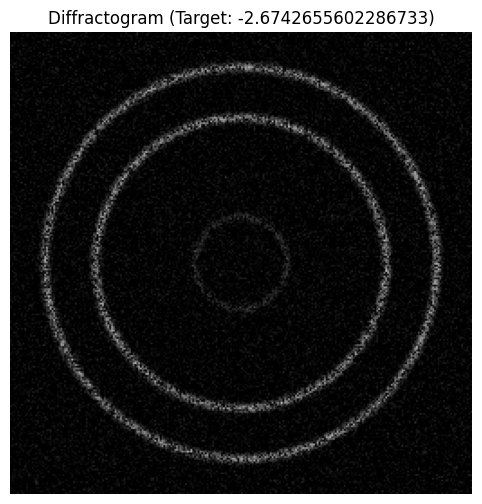

In [31]:
# e.g Data exploration
import matplotlib.pyplot as plt
from PIL import Image


def plot_diffractogram(image: Image, target: float) -> None:
    """
    Plots the given diffractogram image and its target value.
    
    :param image: The diffractogram image as a PIL.Image object.
    :param target: The target value as a float.
    """
    
    plt.figure(figsize=(8, 6))
    plt.imshow(image, cmap='gray')
    plt.title(f'Diffractogram (Target: {target})')
    plt.axis('off')
    plt.show()


# Plot an example diffractogram
example_index = 100
example_data = index_data_map_train[example_index]
example_image = example_data['image']
example_target = example_data['data']['target']


plot_diffractogram(example_image, example_target)

The following cell downloads the 15 elements of the basement test set that have been manually annotated by your collaborators and which you may use to validate your model. Make sure you understand which kinds of distortions are present in the dataset and how they may impact the performance of your approach.

loading the test set...
> Downloaded 1044686 bytes from https://bwsyncandshare.kit.edu/s/XBe7BC8KwBbbMZQ/download/test_sample.zip
> Unzipping /var/folders/08/h7dqgln97rx04lcwp3lfcqb40000gn/T/tmp5ctmdquu/test_sample.zip to /var/folders/08/h7dqgln97rx04lcwp3lfcqb40000gn/T/tmp5ctmdquu


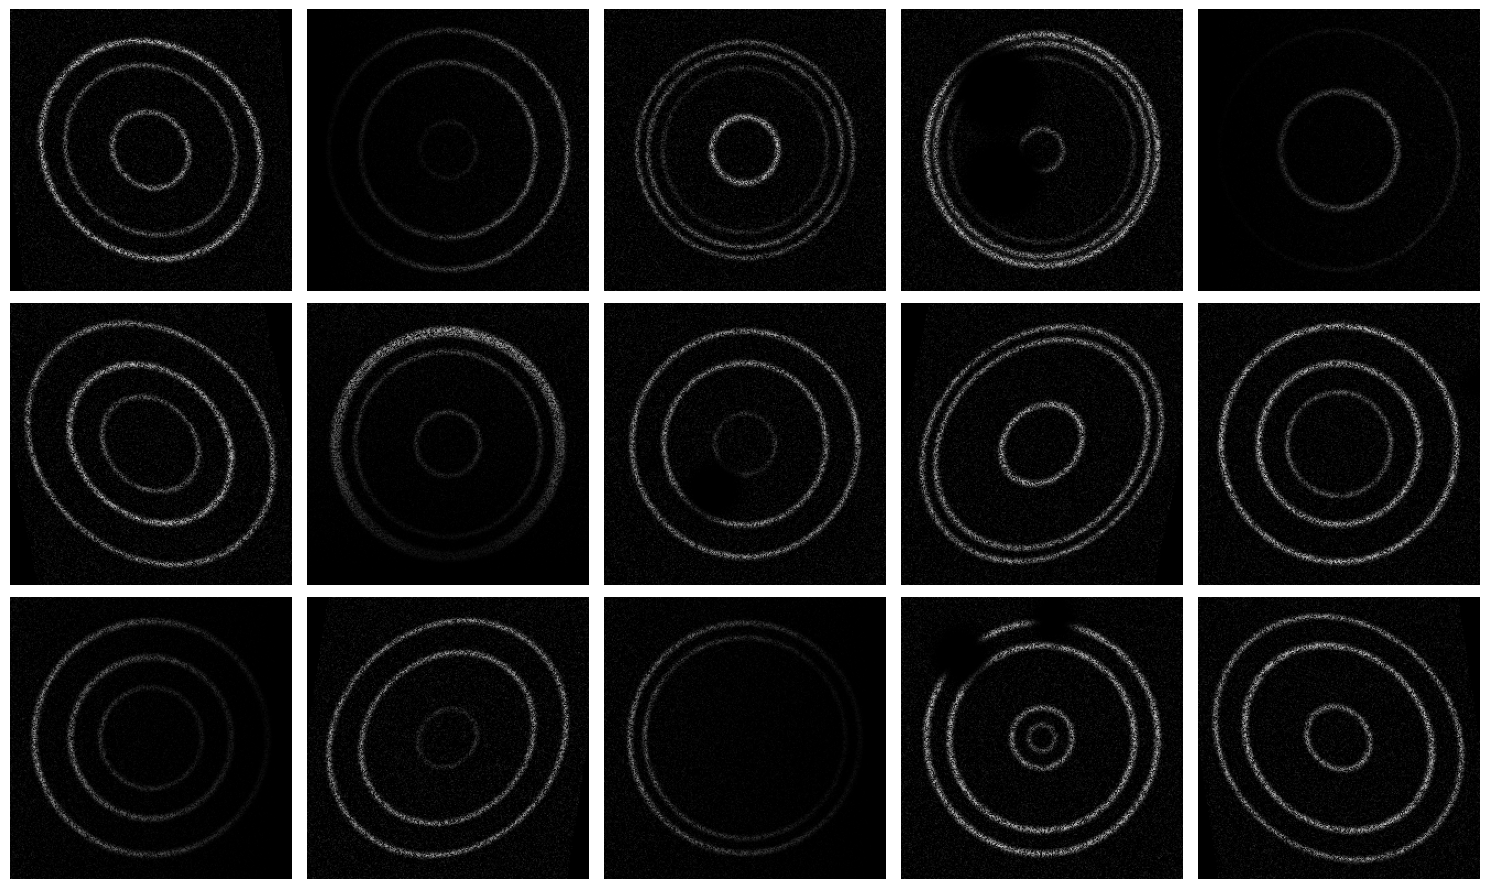

In [32]:
##### DO NOT CHANGE #####
# Loading some samples from the basement set 

print('loading the test set...')
index_data_map_sample: Dict[int, dict] = download_dataset(
    url='https://bwsyncandshare.kit.edu/s/XBe7BC8KwBbbMZQ/download/test_sample.zip',
    name='test_sample',
)

images_sample: List[Image_] = [data['image'] for index, data in index_data_map_sample.items()]

# Plotting the sample images
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
for idx, ax in enumerate(axes.flat):
    if idx < len(images_sample):
        ax.imshow(images_sample[idx])
        ax.axis('off')
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

##### DO NOT CHANGE #####

### Mock Implementation

The following cell showcases a mock implementation of the ``DiffractogramInterface`` using a pytorch lightning ``LightningModule``, as it was introduced in the first part of this exercise. The mock implementation is a simple fully-connected network which takes the flattened image as input and produces a single output value. This implementation is not expected to yield good results, but it serves to illustrate how to implement the interface.

Perhaps more specifically, the mock implementation also showcases how to *save* and *load* a trained model to and from a file format. This will be important for your final submission, as you'll have to save your trained model and load it from your nextcloud file storage during the grading of your submission! You may use the following implementations of the ``save`` and ``load`` methods as a template for your own model.

In [33]:
##### DO NOT CHANGE #####

class MockDiffractogramModel(pl.LightningModule, DiffractogramInterface):
    """
    This mock implementation illustrates how to use the ``DiffractorgramInterface`` 
    to build a very simple pytorch lightning ``LightningModule`` model for the processing 
    of the diffractogram images.
    
    The model consists of a simple fully connected neural network with a single hidden layer.
    The forward pass of the model flattens the 2D image representation and passes it through 
    the network to obtain a single, unconstrained output value.
    """
    def __init__(self,
                 input_shape: Tuple[int, int],
                 output_size: int = 1,
                 ):
        
        pl.LightningModule.__init__(self)
        DiffractogramInterface.__init__(self)
        
        # ~ define hyperparameters
        
        self.input_shape = input_shape
        self.output_size = output_size
        
        self.hparams.update({
            'input_shape': input_shape,
            'output_size': output_size
        })
        
        # ~ define network architecture
        
        flat_size = np.prod(self.input_shape)
        self.lay_pred = nn.Sequential(
            nn.Linear(flat_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        This function takes a batch of images in the format of a torch tensor 
        and returns the batched tensor prediction.
        
        :param x: The input image as a torch tensor.
        
        :returns: The model prediction as a batched torch tensor.
        """
        x = x.view(x.size(0), -1)
        out = self.lay_pred(x)
        return out
    
    def forward_image(self, image: Image, **kwargs) -> float:
        """
        This function converts the image to a proper torch tensor 
        and runs the forward pass of the model to obtain the prediction 
        of the target value.
        
        :param image: The input image as a PIL Image object.
        
        :returns: The model prediction as a native python float value.
        """
        # Convert the image to a numpy array
        image_np = np.array(image)
        
        # Convert the numpy array to a torch tensor
        image_tensor = torch.from_numpy(image_np).float()
        
        # Add batch dimension
        image_tensor = image_tensor.unsqueeze(0)
        
        with torch.no_grad():
            
            # Run the forward pass of the model
            prediction = self.forward(image_tensor)
            
        # Return the prediction as a python float value
        return prediction.item()
    
    # -- SAVING AND LOADING --
    # Pytorch Lightning provides a relatively convenient way to save and load a model 
    # to and from a checkpoint file. The checkpoint file will contain the model's weights
    # at the point of saving, as well as the hyperparameters (constructor arguments).
    # NOTE: To make sure that the saving and loading works, we need to make sure that 
    #       ``hparams`` attriubute (part of the ``LightningModule``) is updated with all 
    #       of the constructor arguments relevant to the construction of the model
    #       architecture.
    
    def save(self, path: str) -> None:
        """
        Saves the current version of the model to the given absolute file ``path``
        """
        
        # NOTE: This has to be done to properly save all of the model information 
        #       in a checkpoint file, which is then required to load the model.
        #       You may not modify the given parts of the dictionary.
        torch.save({
            'state_dict': self.state_dict(),
            'hparams': self.hparams,
            'pytorch-lightning_version': pl.__version__,
        }, path)
    
    @classmethod
    def load(cls, path: str) -> 'MockDiffractogramModel':
        """
        Loads and returns a model instance from the given absolute file ``path``
        pointing to an existing checkpoint file.
        """
        return cls.load_from_checkpoint(path)

##### DO NOT CHANGE #####

In [34]:
##### DO NOT CHANGE #####
# ~ constructing the model
model = MockDiffractogramModel(
    input_shape=(256, 256, 3),
    output_size=1
)

# ~ example usage
example = index_data_map_train[0]
output = model.forward_image(
    image=example['image']
)
assert isinstance(output, float), (
    "The output of the forward_image method should be a single float!"
)

# ~ Saving and loading the model
model_path = os.path.join(PATH, 'model.ckpt')
model.save(model_path)

model_loaded = MockDiffractogramModel.load(model_path)
output_loaded = model_loaded.forward_image(
    image=example['image']
)

assert output == output_loaded, (
    "The output of the loaded model should be the same as the output of the original model!"
)

##### DO NOT CHANGE #####

### Model Training

You may use the following section to define your model architecture and to implement a training loop.

<div class="alert alert-block alert-warning">
<b>Note - Remove Training Code.</b> While you can use the following cells for the training of your model, keep in mind that you <im>should not remove or add any cells</im>. Additionally make sure to <im>disable</im> your training code before submitting your solution! (due to the cell execution timeout)
</div>

In [50]:
# e.g. instantiate your model class
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl

# Example Dataset (replace with your own diffraction dataset)
class DiffractionDataset(Dataset):
    def __init__(self, images, energies, transform=None):
        """
        images: Tensor of shape [N, C, H, W]
        energies: Tensor of shape [N]
        """
        self.images = images
        self.energies = energies
        self.transform = transform

    def __len__(self):
        return len(self.energies)

    def __getitem__(self, idx):
        x = self.images[idx]
        y = self.energies[idx]
        if self.transform:
            x = self.transform(x)
        return x, y


# CNN Model for regression
class DiffractionEnergyCNN(pl.LightningModule, DiffractogramInterface):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  
            nn.LeakyReLU(),
            nn.MaxPool2d(2),  

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  
            nn.LeakyReLU(),
            nn.MaxPool2d(2), 

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2), 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2), 
            nn.AdaptiveAvgPool2d((4, 4)),  # Output size fixed: [B, 64, 4, 4]


        )

        self.regressor = nn.Sequential(
            nn.Flatten(),  # [B, 64*4*4]
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.cnn(x)
        return self.regressor(x).squeeze(1)  # [B]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.mse_loss(y_hat, y)
        self.log("val_loss", val_loss)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        test_loss = F.mse_loss(y_hat, y)
        self.log("test_loss", test_loss, prog_bar=True)
        return {"test_loss": test_loss}


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

    def forward_image(self, image: Image, **kwargs) -> float:
        """
        This function converts the image to a proper torch tensor 
        and runs the forward pass of the model to obtain the prediction 
        of the target value.
        
        :param image: The input image as a PIL Image object.
        
        :returns: The model prediction as a native python float value.
        """
        # Convert the image to a numpy array
        image_np = np.array(image)
        
        # Convert the numpy array to a torch tensor
        image_tensor = torch.from_numpy(image_np).float()
        
        # Add batch dimension and channel dimension
        image_tensor = image_tensor.unsqueeze(0)
        with torch.no_grad():
            # Run the forward pass of the model
            prediction = self.forward(image_tensor)
        
        # Return the prediction as a python float value
        return prediction.item()



In [51]:
# e.g. implemenet the training loop
# splot index_data_map_train into energies and images
from torchvision import transforms
from tqdm import tqdm
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader, Dataset, random_split
from pytorch_lightning.callbacks import EarlyStopping

torch.manual_seed(42)  # For reproducibility

data_dict = index_data_map_train  # Replace with your actual dictionary



# Define image transform (e.g., to tensor)
transform = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.ColorJitter(0.2,0.2,0.8,0.2)  # Converts PIL to tensor in [0,1], shape [C, H, W]
])

# Extract into two lists
image_list = []
target_list = []

for entry in tqdm(data_dict.values()):
    img = entry['image']
    target = entry['data']['target']
    
    img_tensor = transform(img)  # shape: [3, 256, 256]
    
    image_list.append(img_tensor)
    target_list.append(target)

mean = torch.stack(image_list).mean(dim=[0, 2, 3])  # shape: [3]
std = torch.stack(image_list).std(dim=[0, 2, 3])    # shape: [3]

transform_normalize = transforms.Normalize(
    mean=mean,  # Normalization values for RGB channels
    std=std     # Standard deviation values for RGB channels
)

# Apply normalization transform
image_list = [transform_normalize(img) for img in image_list]  # shape: [3, 256, 256]
# Ensure all images are of the same size

# Convert to stacked tensors
images = torch.stack(image_list)       # shape: [N, 3, 256, 256]
targets = torch.tensor(target_list)    # shape: [N]

dataset = DiffractionDataset(
    images = images,
    energies = targets
)

train_set, val_set = random_split(dataset, [0.9, 0.1])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle = False)

checkpoint = ModelCheckpoint(monitor="val_loss",  mode="min")

early_stop_callback = EarlyStopping(
    monitor="val_loss",     # Metric to monitor
    patience=10,             # Number of epochs with no improvement after which to stop
    mode="min",             # "min" because we want to minimize val_loss
    verbose=True
)

trainer = Trainer(
    max_epochs=1000,
    accelerator="auto",
    callbacks=[checkpoint, early_stop_callback]
)

model = DiffractionEnergyCNN(lr=1e-3)


trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
trainer.test(model, dataloaders=val_loader)

100%|██████████| 5000/5000 [00:36<00:00, 138.14it/s]
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | cnn       | Sequential | 97.4 K | train
1 | regressor | Sequential | 262 K  | train
-------------------------------------------------
359 K     Trainable params
0         Non-trainable params
359 K     Total params
1.439     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/christopherroth/code/ml/ml_natural_sciences/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/christopherroth/code/ml/ml_natural_sciences/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 2.949


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.976 >= min_delta = 0.0. New best score: 1.973


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.395 >= min_delta = 0.0. New best score: 1.578


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.435 >= min_delta = 0.0. New best score: 1.143


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.259 >= min_delta = 0.0. New best score: 0.883


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.290 >= min_delta = 0.0. New best score: 0.594


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.185 >= min_delta = 0.0. New best score: 0.409


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.368


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 0.297


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 0.232


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.198


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.197


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.149


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.144


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.126


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.116


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.101


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.093


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.088


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.088. Signaling Trainer to stop.
/Users/christopherroth/code/ml/ml_natural_sciences/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.09588261693716049    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.09588261693716049}]

### Model Evaluation

You may use this section to evaluate your model.

In [52]:
from collections import defaultdict
from sklearn.metrics import r2_score
import torchvision.transforms as transforms

def preprocess_image(pil_image):
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transform_normalize, # Converts to [C, H, W] and normalizes to [0, 1]
    ])
    image_tensor = transform(pil_image)  # Add batch dimension
    return image_tensor

def report_ps_score(model: pl.LightningModule, test_data: dict) -> float:
    grouped_targets = defaultdict(list)
    grouped_predictions = defaultdict(list)

    for item in test_data.values():
        tag = item['data']['tag']
        grouped_targets[tag].append(item['data']['target'])
        grouped_predictions[tag].append(model.forward_image(preprocess_image(item['image'])))

    r2_scores = []

    for tag in grouped_targets:
        y_true = grouped_targets[tag]
        y_pred = grouped_predictions[tag]
        score = r2_score(y_true, y_pred)
        r2_scores.append(score)
        print(f"Tag: {tag}, R2 Score: {score:.4f}")
    PS = sum(r2_scores) / len(r2_scores)

    return PS

# e.g. plot the training loss of the model
#trainer.test(model, dataloaders=val_loader)

# load the test_sample dataset
report_ps_score(model, index_data_map_sample)
# YOUR CODE HERE


/var/folders/08/h7dqgln97rx04lcwp3lfcqb40000gn/T/ipykernel_16136/445459420.py:103: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image_np = np.array(image)


Tag: distort_shear, R2 Score: -3.2455
Tag: distort_gradient, R2 Score: -0.9543
Tag: distort_blotches, R2 Score: 0.9600


-1.0799265859875264

In [ ]:
# e.g. evaluate the model performance on the sample test elements

# YOUR CODE HERE
raise NotImplementedError()

### Final Submission

The following section defines your final submission to the competition. Make sure to assign an instance of your trained model to the ``MODEL`` variable below.

### Loading from BwSync&Share

Due to the cell execution timeout of 5 minutes, it won't be possible to train your model during the grading of your submission. Instead, you'll have to save your trained model to a file and load it from your nextcloud file storage during the grading. To do this, you'll first have to export your trained model to a file using a ``save`` method or similar functionality provided by the machine learning framework of your choice. Then you'll have to uplod the checkpoint file to your nextcloud file storage at https://bwsyncandshare.kit.edu/.

After uploading the file, you'll have to create a *public sharing line* for the file. See the image below for an example of how to do this: First click the share symbol to open the share dialog, then click the "+" button next to the "Share Link" field. Pressing this button will automatically create the public URL and copy it to your clipboard.

<img src="https://bwsyncandshare.kit.edu/s/PiXDbKTgxe3nPBk/download" alt="Download Link">

After obtaining the public URL, you can use the following code snippet to download the file content and load the model checkpoint:
```python

with tempfile.TemporaryDirectory() as temp_path:

    file_path = os.path.join(temp_path, "model.ckpt")
    with open(file_path, "wb") as file:
        
        # NOTE: You'll have to replace with your own URL and not forget to add the "/download" suffix!
        content = nextcloud_download(
            url="{your_url}/download",
            raw=True
        )
        file.write(content)

        # Load the model checkpoint from the file...

```

### Pre-Submission Checklist 📋

- [ ] Does your notebook still contain the required nbgrader metadata?
- [ ] Are you certain that you have not added or removed any cells? 
- [ ] Have you removed/disabled the training code?
- [ ] Have you defined your model in the cell below?
- [ ] Are you loading your model in such a way that it will work in the grading environment? E.g. by downloading 
  the checkpoint from nextcloud?
- [ ] Does your model implementation pass the public test cases below?

In [ ]:
# NOTE: Make sure to load and assign a *working and trained* version of the model to 
#       this ``MODEL`` variable!
#       The model assigned to this variable will be considered as your final submission
#       to the challenge.
MODEL: DiffractogramInterface = None

# YOUR CODE HERE
raise NotImplementedError()

The following cell declares ungraded, *public tests* only. These public tests shall help you to properly check your model for the submission. If your submitted model does not pass the following test cases, the submission will most likely fail! To guarantee a smooth submission make sure that your model properly adheres to the ``DiffractogramInterface``.

In [ ]:
##### DO NOT CHANGE #####
# There has to be some kind of model assigned to the MODEL variable.
assert MODEL is not None, (
    "The MODEL variable has not been assigned a model yet!"
)

# The model instance has to be a subclass of the ``DiffractogramInterface`` class 
# and therefore implement the ``forward_image`` method.
assert isinstance(MODEL, DiffractogramInterface), (
    "The submitted MODEL variable has to be a subclass of the DiffractogramInterface class!"
)
assert hasattr(MODEL, 'forward_image'), (
    "The submitted MODEL variable has to implement the forward_image method!"
)

# It has to be possible to run the forward pass of the model using a PIL.Image object  
# representing an RGB image and the shape (256, 256, 3).
import numpy as np
from PIL import Image
example_image = Image.fromarray(
    np.random.randint(0, 256, (256, 256, 3), dtype=np.uint8)
)
output = MODEL.forward_image(image=example_image)
print(f'* example model output: {output:.3f}')

# The output of the forward pass has to be a single float value!
assert isinstance(output, float), (
    "* The output of the forward_image method should be a single float!"
)

# Each forward pass of the model should be faster than 1 second on average. If the forward 
# pass takes longer than 1 second, it is possible that the evaluation of the hidden test 
# set will fail due to a cell execution timeout!
# Regarding this time constraint, beware that the execution speed will likely differ between 
# the collab environment and the grading environment. To be on the safe side, make sure to
# keep the inference time of your model low.
import time
num_elements = 10
start_time = time.time()
for i in range(num_elements):
    output = MODEL.forward_image(image=example_image)
    
end_time = time.time()
duration = (end_time - start_time) / num_elements
print(f'* average duration: {duration:.3f} seconds')
assert duration < 1, (
    "The forward pass of the model takes longer than 1 second on average!"
)

print('✅ your model is most likely ready for submission')

##### DO NOT CHANGE #####

### 📝 Grading

The following section contains the hidden tests related to the *bonus* grading part of the competition. Make sure not to modify the cells!

In [ ]:
##### DO NOT CHANGE #####
# ID: comp-easy - possible points: 3

# NOTE: This hidden test will evaluate the model performance on the hidden test set and 
#       check if the model performance score is above the 3 point threshold.


##### DO NOT CHANGE #####

In [ ]:
##### DO NOT CHANGE #####
# ID: comp-medium - possible points: 3

# NOTE: This hidden test will evaluate the model performance on the hidden test set and 
#       check if the model performance score is above the 6 point threshold.


##### DO NOT CHANGE #####

In [ ]:
##### DO NOT CHANGE #####
# ID: comp-hard - possible points: 3

# NOTE: This hidden test will evaluate the model performance on the hidden test set and 
#       check if the model performance score is above the 9 point threshold.


##### DO NOT CHANGE #####

### 🏆 Competition

The following section contains the hidden tests related to the competition part of the competition. Make sure not to modify the cells!

In [ ]:
##### DO NOT CHANGE #####
# ID: comp-ranking - possible points: 1

# NOTE: This hidden test will evaluate the model performance on the hidden test set and 
#       provide the model performance score that will be compared in the context of the
#       competition leaderboard.


##### DO NOT CHANGE #####